**Item requerido:** Utilizar uma rede CNN pré-treinada:
- Escolher o modelo de rede
- Realizar transferência de aprendizado
- Verificar resultados e tempo de aprendiz

## Base de Dados

In [ ]:
!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content' 'smaranjitghose/corn-or-maize-leaf-disease-dataset'

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

!unzip corn-or-maize-leaf-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 90% 145M/161M [00:01<00:00, 132MB/s]
100% 161M/161M [00:01<00:00, 121MB/s]
Archive:  corn-or-maize-leaf-disease-dataset.zip
  inflating: data/Blight/Corn_Blight (1).jpeg  
  inflating: data/Blight/Corn_Blight (1).jpg  
  inflating: data/Blight/Corn_Blight (10).jpg  
  inflating: data/Blight/Corn_Blight (100).jpg  
  inflating: data/Blight/Corn_Blight (1000).JPG  
  inflating: data/Blight/Corn_Blight (1001).JPG  
  inflating: data/Blight/Corn_Blight (1002).JPG  
  inflating: data/Blight/Corn_Blight (1003).JPG  
  inflating: data/Blight/Corn_Blight (1004).JPG  
  inflating: data/Blight/Corn_Blight (1005).JPG  
  inflating: data/Blight/Corn_Blight (1006).JPG  
  inflating: data/Blight/Corn_Blight (1007).JPG  
  inflating: data/Blight/Corn_Blight (1008).JPG  
  inflating: data/Blight/Corn_Blight (1009).JPG  
  inflating: data/Blight/Corn_Blight (101).jpg  
  inflati

### Carregando Dataset em Tensor do pyTorch

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder

# Definindo o diretório raiz dos dados
root_dir = '/content/data/'

transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Carregando o dataset completo
dataset = ImageFolder(root_dir, transform)

# Dividindo o dataset em conjuntos de treinamento, validação e teste
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Criando os dataloaders para treinamento, validação e teste
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
}

class_names =  dataset.classes

print('Classes:', class_names)


Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualizando Dados

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


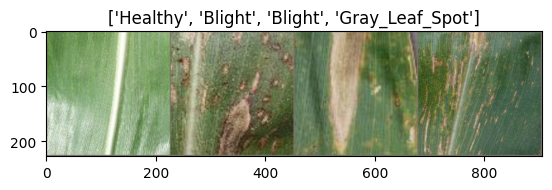

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# imshow para imagens em tensores
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dataset.classes[x] for x in classes])

## ResNet versão 18

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.4MB/s]


### Transfer Learning

In [ ]:
import time
import copy

def treinamento(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Época {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
          scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Perda: {epoch_loss:.4f} Acur: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Treinamento completo em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Melhor acurácia: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

model_ft = treinamento(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Época 0/24
----------
train Perda: 0.6713 Acur: 0.7510
val Perda: 0.3834 Acur: 0.8711

Época 1/24
----------
train Perda: 0.5468 Acur: 0.8042
val Perda: 0.3220 Acur: 0.8771

Época 2/24
----------
train Perda: 0.4795 Acur: 0.8340
val Perda: 0.2465 Acur: 0.9189

Época 3/24
----------
train Perda: 0.4130 Acur: 0.8582
val Perda: 0.2109 Acur: 0.9248

Época 4/24
----------
train Perda: 0.3532 Acur: 0.8800
val Perda: 0.2419 Acur: 0.9129

Época 5/24
----------
train Perda: 0.3412 Acur: 0.8842
val Perda: 0.2131 Acur: 0.9308

Época 6/24
----------
train Perda: 0.3226 Acur: 0.8878
val Perda: 0.2375 Acur: 0.9129

Época 7/24
----------
train Perda: 0.2464 Acur: 0.9107
val Perda: 0.1643 Acur: 0.9403

Época 8/24
----------
train Perda: 0.2398 Acur: 0.9131
val Perda: 0.1833 Acur: 0.9368

Época 9/24
----------
train Perda: 0.2487 Acur: 0.9113
val Perda: 0.1892 Acur: 0.9379

Época 10/24
----------
train Perda: 0.2401 Acur: 0.9215
val Perda: 0.1924 Acur: 0.9391

Época 11/24
----------
train Perda: 0.2166

### Salvando o modelo treinado

In [ ]:
arquivo_modelo = 'folhasMilhoDP.pth'
torch.save(model_ft,arquivo_modelo)
from google.colab import files
files.download(arquivo_modelo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Avaliando o Treinamento

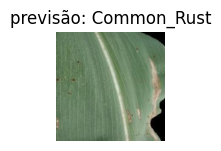

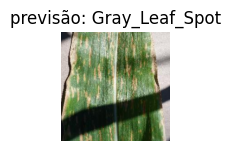

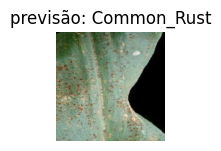

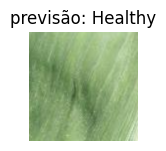

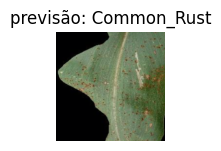

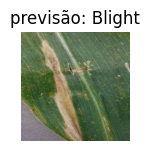

In [ ]:
def visualizando(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'previsão: {dataset.classes[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
            model.train(mode=was_training)
            return
  model.train(mode=was_training)

visualizando(model_ft)